In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as T

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/d2l.ai_implementation/chapter11')

In [5]:
from VisionTransformer import ViT

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [7]:
transform = T.Compose([
    T.Resize((96, 96)),
    T.ToTensor(),
    T.Normalize(0.2860, 0.3530)
])

In [8]:
root = '/content'
train_data = FashionMNIST(
    root,
    train=True,
    transform=transform,
    download=True
)
test_data = FashionMNIST(
    root,
    train=False,
    transform=transform,
    download=True
)

100%|██████████| 26421880/26421880 [00:02<00:00, 9031714.67it/s] 


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169674.54it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 884214.27it/s] 


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22123234.62it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [12]:
def train_run_epoch(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [13]:
@torch.no_grad()
def test_run_epoch(model, device, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        pred = output.argmax(1)
        correct += pred.eq(target).sum().item()

        total_loss += loss.item()

    accuracy = correct / len(test_loader)
    avg_loss = total_loss / len(test_loader)

    return accuracy, avg_loss

In [19]:
def train(model, device, train_loder, test_loader, optimizer, criterion, num_epochs):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(1, num_epochs+1):
        print(f"Epoch [{epoch}/{num_epochs}]")

        train_loss = train_run_epoch(model, device, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        print(f"Train Loss = {train_loss:.20f}")

        accuracy, test_loss = test_run_epoch(model, device, test_loader, criterion)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
        print(f"Test Loss = {test_loss:.20f}")
        print(f"Test Accuracy = {accuracy:.2f}")
        print()

    return train_losses, test_losses, accuracies

In [9]:
batch_size = 128
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout = 0.1, 0.1

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [27]:
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [28]:
num_epochs = 10
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
train_losses, test_losses, accuracies = train(model, DEVICE, train_loader, test_loader, optimizer, criterion, num_epochs)

Epoch [1/10]
Train Loss = 2.21682244882400603103
Test Loss = 1.90005728111991389895
Test Accuracy = 37.85

Epoch [2/10]
Train Loss = 1.91780693342944963398
Test Loss = 1.87932241415675682639
Test Accuracy = 37.85

Epoch [3/10]
Train Loss = 1.83540476359792359418
Test Loss = 1.77464833138864253037
Test Accuracy = 42.57

Epoch [4/10]
Train Loss = 1.81997843795239533371
Test Loss = 1.71659274493591684774
Test Accuracy = 47.86

Epoch [5/10]
Train Loss = 1.80124991204438678061
Test Loss = 1.71479234665255009240
Test Accuracy = 45.52

Epoch [6/10]
Train Loss = 1.65097114348462392641
Test Loss = 1.77666091466251807596
Test Accuracy = 41.65

Epoch [7/10]
Train Loss = 1.63672132227720745767
Test Loss = 1.54097463209417795404
Test Accuracy = 54.63

Epoch [8/10]
Train Loss = 1.59221482632765121146
Test Loss = 1.60758948175213012277
Test Accuracy = 45.92

Epoch [9/10]
Train Loss = 1.62289748364674246695
Test Loss = 1.45679618889772433121
Test Accuracy = 58.15

Epoch [10/10]
Train Loss = 1.49964797

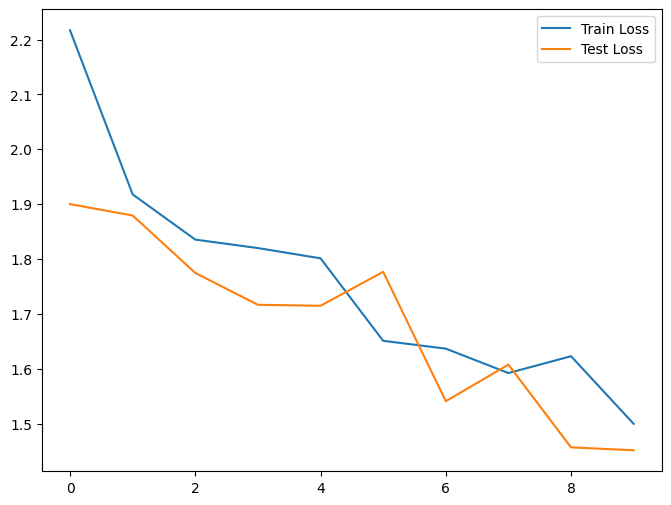

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

plt.show()